# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

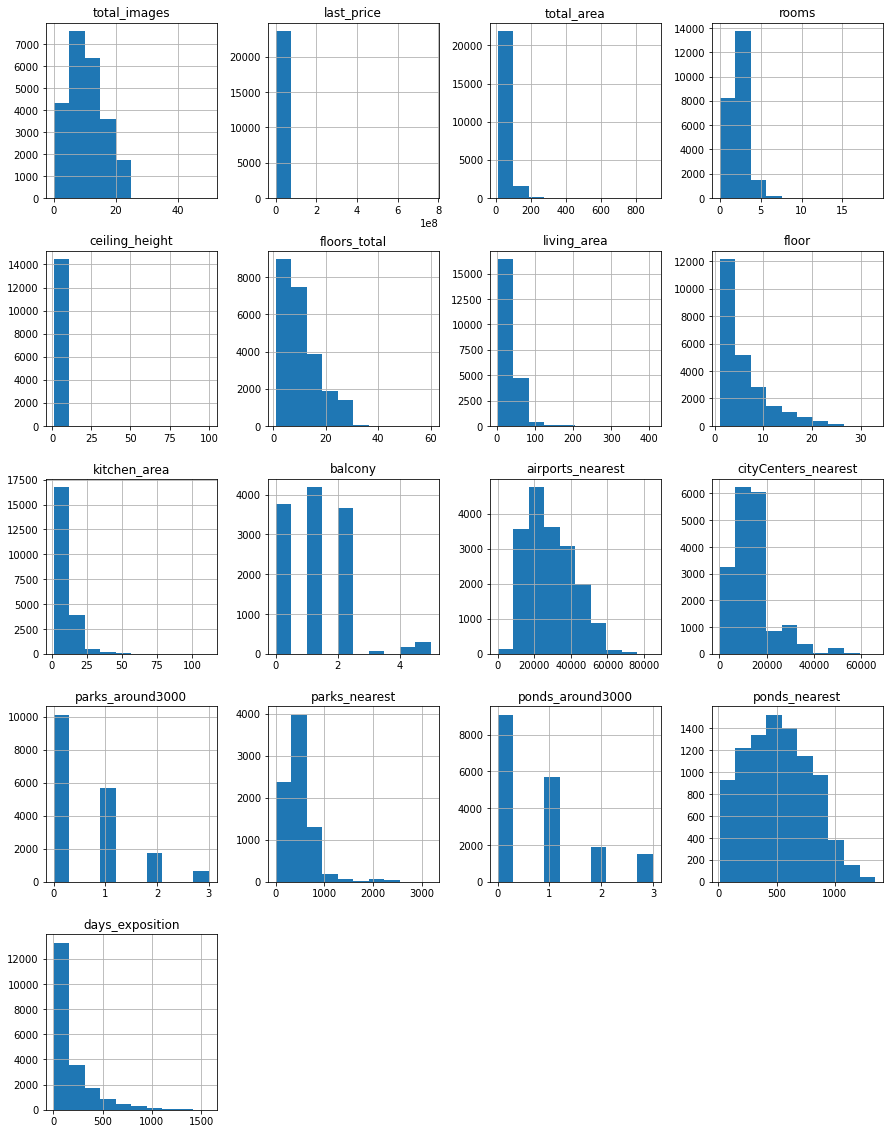

In [5]:
data.hist(figsize=(15, 20))

In [27]:
data.duplicated().sum() #поиск явных дубликатов

0

В предоставленных данных 23699 строки и 22 столбца. Есть пропуски данных в 14 столбцах (в пункте ниже расписано в каких). Явные дубликаты отсутствуют. Есть выраженные положительные выбросы в столбцах 'last_price', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area'. В столбце 'first_day_exposition' (дата публикации) неверный тип данных, необходимо его изменить на datetime, в столбце 'is_apartment' на bool, в столбцах 'balcony', 'floors_total', 'parks_around3000', 'ponds_around3000', 'days_exposition' на int

### Выполните предобработку данных

In [46]:
data.isna().mean().sort_values(ascending=False)*100 #доля пропущенных значений по столбцам

is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
balcony                 48.605426
ceiling_height          38.799105
airports_nearest        23.384953
cityCenters_nearest     23.287902
ponds_around3000        23.283683
parks_around3000        23.283683
days_exposition         13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
total_images             0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v1<a class="tocSkip"></h2>

<b>На доработку🤔:</b> Пропуски нужно посмотреть явно. Такие таблицы важно сортировать от большего количества пропусков к меньшему. Также полезно посмотреть на доли пропусков по столбцам, чтобы сразу была возможность принять решение об удалении прпоусков, например. Для этого удобно использовать:


            isna().mean()*100

<div class="alert alert-info">
<h2>Комментарий v1<a class="tocSkip"></h2>

<b>Я понял, хорошее замечание, почему-то все пропуски смотрел через .info из предыдущего пункта, даже в голову не пришло так сделать</b> 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Исправлено!

#### Поиск пропущенных значений
Пропущенные значения есть в столбцах:
* ceiling_height - высота потолков (м) <b>(пропущено почти половина)</b>
* floors_total - всего этажей в доме (мало пропусков)
* living_area - жилая площадь в квадратных метрах (м²) (мало пропусков)
* is_apartment - апартаменты (булев тип) <b>(пропущено очень много, предположу, что все пропущенные это не апартаменты)</b>
* kitchen_area - площадь кухни в квадратных метрах (м²) (мало пропусков)
* balcony - число балконов <b>(пропущено почти половина, предположу, что все пропущенные это квартиры без балкона)</b>
* locality_name - название населённого пункта (мало пропусков)
* airports_nearest - расстояние до ближайшего аэропорта в метрах (м) <b>(пропущено около четверти)</b>
* cityCenters_nearest - расстояние до центра города (м) <b>(пропущено около четверти)</b>
* parks_around3000 - число парков в радиусе 3 км <b>(пропущено около четверти)</b>
* parks_nearest - расстояние до ближайшего парка (м) <b>(пропущено больше половины)</b>
* ponds_around3000 - число водоёмов в радиусе 3 км <b>(пропущено около четверти)</b>
* ponds_nearest - расстояние до ближайшего водоёма (м) <b>(пропущено больше половины)</b>
* days_exposition - сколько дней было размещено объявление (от публикации до снятия) (мало пропусков)


In [4]:
data['balcony'] = data['balcony'].fillna(0) #заменяем пропущенные значения в столбце 'balcony' на 0
data['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

In [5]:
data['is_apartment'] = data['is_apartment'].fillna(False) #заменяем пропущенные значения в столбце 'is_apartment' на False
data['is_apartment'].unique()

array([False,  True])

<div class="alert alert-success">
<h2> Комментарий ревьюера v1 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Пропуски заполнены верно!

Возможные причины пропусков:
* ceiling_height - странно что так много пропусков в этой колонке, возможно, при заполнении данных о квартире многие пользователи не видят эту графу о высоте потолка
* living_area, kitchen_area - +/- одинаковое кол-во пропусков, возможно, у этих пользователей совмещены кухня и жилое помещение
* airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000 - +/- одинаковое кол-во пропусков, скорее всего не были/некорректно получены данные от геосервисов
* parks_nearest, ponds_nearest - аналогичное объяснение (см. предыдущий пункт) только пропусков больше, т.к. там где в столбце parks/ponds_around3000 - ноль, в столбце parks/ponds_nearest - пропуски
* days_exposition - здесь, возможно, пропуски связаны с тем, что на момент выгрузки датафрейма часть публикаций были актуальны

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v1<a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> Заполнено очень мало прпоусков - можно попробовать заполнить пррпоуски в площаадях, напримеер, количество прудов и парков

<div class="alert alert-info">
<h2>Комментарий v1<a class="tocSkip"></h2>

<b>У меня вопрос, а какой целевой смысл заполнять пропуски там, где ты не знаешь что должно быть? Только ради того чтобы изменить тип данных в столбце? И если в этом есть смысл, то я правильно понимаю, что заполнять медианой/средним значением нужно столбцы где мало пропусков (в данном случае это kitchen_area, living_area, floors_total), иначе же они могут исказить реальное положение дел?</b> 
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> Правильно понимаешь! Пропуски можно заполнять там, где их немного. Для этого можно использовать медиану, моду, среднее

#### Изменение типа данных столбцов

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #меняем тип данных столбца 'first_day_exposition'
data['is_apartment'] = data['is_apartment'].astype('bool') #меняем тип данных столбца 'is_apartment'
data['balcony'] = data['balcony'].astype('int') #меняем тип данных столбца 'balcony'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

1. 'first_day_exposition': object -> datetime64 (в этом столбце дата размещения объявления, поэтому используем datetime)
2. 'is_apartment': object -> bool (здесь только два возможных варианта True/False, поэтому используем bool, т.к. занимает меньше памяти)
3. 'balcony': float64 -> int64 (кол-во балконов всегда целое, поэтому используем int, т.к. занимает меньше памяти)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v1<a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> Если выше зполним больше пропусков, то можно больше типов данных привести

#### Устранение неявных дубликатов

In [7]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') #заменяем е на ё в столбце 'locality_name': получаем из 365 -> 331 уникальное значение
len(data['locality_name'].unique())

331

In [8]:
filtred_data = data[(data['locality_name'].isna() == False) & (data['locality_name'].str.contains('поселок'))] #фильтруем дф, где в названии местности есть слово поселок

def find_uppercase_char_key(s): #для удобства поиска неявных дубликатов создаем функцию поиска заглавной буквы в строке
    for char in s:
        if char.isupper():
            return char

sorted(filtred_data['locality_name'].unique(), key=find_uppercase_char_key) #сортируем отфильтрованный дф с уникальными названиями по заглавной букве

['поселок Аннино',
 'поселок Александровская',
 'поселок Алексеевка',
 'поселок Бугры',
 'городской поселок Большая Ижора',
 'поселок Барышево',
 'городской поселок Будогощь',
 'поселок Белоостров',
 'поселок городского типа Большая Ижора',
 'поселок городского типа Вырица',
 'поселок станции Вещево',
 'поселок Войсковицы',
 'поселок Войскорово',
 'поселок городского типа Важины',
 'городской поселок Виллози',
 'поселок Возрождение',
 'поселок при железнодорожной станции Вещево',
 'поселок городского типа Вознесенье',
 'поселок Высокоключевой',
 'поселок Володарское',
 'поселок Гаврилово',
 'поселок Глажево',
 'поселок Глебычево',
 'поселок Гончарово',
 'поселок станции Громово',
 'поселок Гладкое',
 'поселок Гарболово',
 'поселок Громово',
 'поселок городского типа Дубровка',
 'поселок городского типа Дружная Горка',
 'поселок Дружноселье',
 'поселок Дзержинского',
 'поселок городского типа Ефимовский',
 'поселок Елизаветино',
 'поселок Жилпоселок',
 'поселок Житково',
 'поселок Жилго

Изучив полученный список, находим неявные дубликаты (возможно не все, получилось затратно это все проверять): Лесогорский, Мга, Назия, Павлово, Рощино, Советский - все эти названия одного и того же населенного пункта указаны в разных интерпретациях (кстати, в инструкции в качестве примера указан поселок Рябово, но в Ленинградской области есть и поселок Рябово, и поселок городского типа Рябово - решил не объединять)
P.S. зря душился :)

In [9]:
data = data.replace('поселок городского типа Лесогорский', 'городской поселок Лесогорский')
data = data.replace('поселок городского типа Мга', 'городской поселок Мга')
data = data.replace('поселок городского типа Назия', 'городской поселок Назия')
data = data.replace('поселок городского типа Павлово', 'городской поселок Павлово')
data = data.replace('поселок городского типа Рощино', 'городской поселок Рощино')
data = data.replace('поселок городского типа Советский', 'городской поселок Советский')
len(data['locality_name'].unique()) #обработав неявные дубликаты, получем из 331 -> 325 уникальных значений

325

<div class="alert alert-success">
<h2> Комментарий ревьюера v1 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Качественная работа с неявными дублями по локации

### Добавьте в таблицу новые столбцы

In [10]:
data['price_per_square'] = data['last_price'] / data['total_area'] #создаем столбец с ценой одного квадратного метра

data['day_of_week'] = pd.DatetimeIndex(data['first_day_exposition']).weekday #создаем столбец с днем недели публикации объявления

data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month #создаем столбец с месяцем публикации объявления

data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year #создаем столбец с годом публикации объявления

def floor_type(row): #функция для категоризации
    floor = row['floor']
    total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == total:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1) #создаем столбец с типом этажа квартиры

data['dist_to_city'] = round(data['cityCenters_nearest'] / 1000) #создаем столбец с расстоянием до центра города в км

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,dist_to_city
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Проведите исследовательский анализ данных

#### Исследование параметров объектов

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

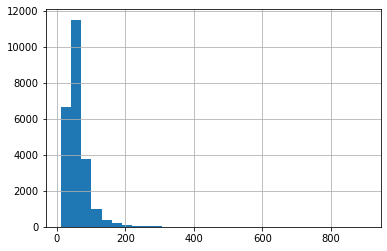

In [12]:
display(data['total_area'].describe()) #общая площадь
data['total_area'].hist(bins=30)

count    21790.000000
mean        34.466404
std         22.027437
min          6.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot:>

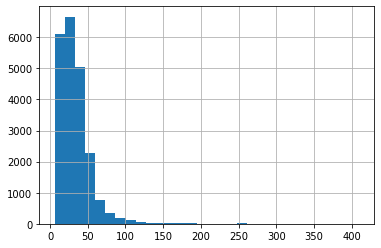

In [13]:
data.loc[data['living_area'] < 6, 'living_area'] = np.nan #заменяем жилую площадь меньше 6 м2 на значения NaN
display(data['living_area'].describe()) #жилая площадь
data['living_area'].hist(bins=30)

count    21316.000000
mean        10.602188
std          5.901569
min          5.000000
25%          7.000000
50%          9.200000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

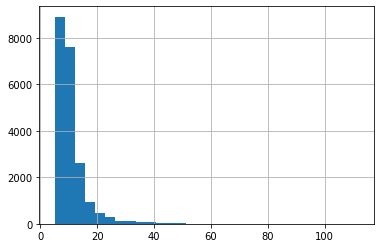

In [14]:
data.loc[data['kitchen_area'] < 5, 'kitchen_area'] = np.nan #заменяем площадь кухни меньше 5 м2 на значения NaN
display(data['kitchen_area'].describe()) #площадь кухни
data['kitchen_area'].hist(bins=30)

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

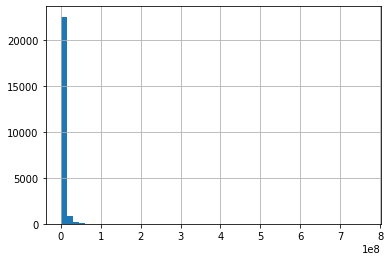

In [15]:
display(data['last_price'].describe()) #цена объекта
data['last_price'].hist(bins=50)

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,dist_to_city
144,1,2450000.0,27.00,2017-03-30,0,NaN,24.0,15.50,2,False,...,NaN,NaN,NaN,181.0,90740.740741,3,3,2017,другой,NaN
349,4,2320000.0,25.00,2017-09-27,0,NaN,14.0,17.00,1,False,...,NaN,NaN,NaN,45.0,92800.000000,2,9,2017,первый,NaN
440,8,2480000.0,27.11,2018-03-12,0,NaN,17.0,24.75,4,False,...,NaN,2.0,982.0,64.0,91479.158982,0,3,2018,другой,15.0
508,0,3375000.0,34.40,2017-03-28,0,NaN,26.0,24.30,19,False,...,NaN,1.0,593.0,430.0,98110.465116,1,3,2017,другой,19.0
608,2,1850000.0,25.00,2019-02-20,0,NaN,10.0,NaN,7,False,...,NaN,NaN,NaN,29.0,74000.000000,2,2,2019,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25.0,18.00,16,False,...,NaN,1.0,623.0,14.0,123076.923077,4,9,2017,другой,13.0
23442,0,2500000.0,27.70,2017-09-28,0,NaN,24.0,18.00,4,False,...,NaN,NaN,NaN,4.0,90252.707581,3,9,2017,другой,NaN
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19.0,NaN,8,False,...,NaN,2.0,112.0,31.0,128846.153846,4,9,2018,другой,17.0
23592,10,1450000.0,29.00,2017-11-11,0,NaN,9.0,18.00,8,False,...,NaN,NaN,NaN,82.0,50000.000000,5,11,2017,другой,NaN


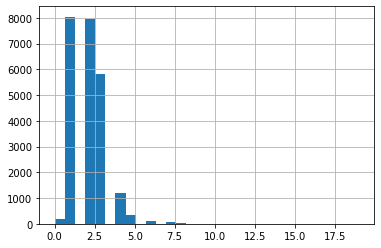

In [16]:
display(data['rooms'].describe()) #кол-во комнат
data['rooms'].hist(bins=30)
data.query('rooms == 0')

count    14488.000000
mean         2.729727
std          0.304588
min          2.200000
25%          2.520000
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

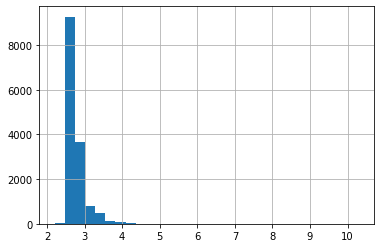

In [17]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 10.4, data['ceiling_height'] / 10) #заменяем ошибочные значения высот на правильные
data.loc[data['ceiling_height'] < 2.2, 'ceiling_height'] = np.nan #заменяем высоты меньше 2,2 м на значения NaN
display(data['ceiling_height'].describe()) #высота потолка
data['ceiling_height'].hist(bins=30)

count      23699
unique         3
top       другой
freq       17446
Name: floor_type, dtype: object

<AxesSubplot:>

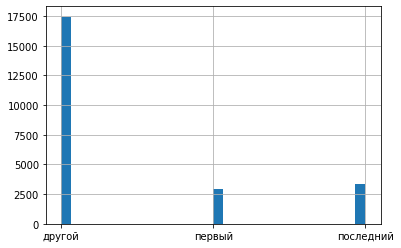

In [18]:
display(data['floor_type'].describe()) #тип этажа квартиры
data['floor_type'].hist(bins=30)

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

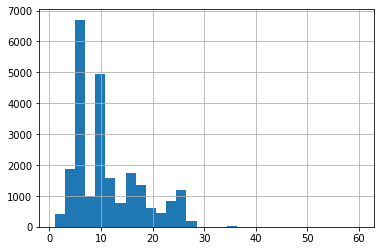

In [19]:
display(data['floors_total'].describe()) #общее кол-во этажей
data['floors_total'].hist(bins=30)

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

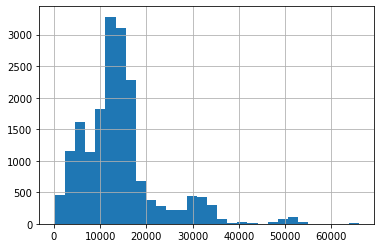

In [20]:
display(data['cityCenters_nearest'].describe()) #расстояние до центра города в метрах
data['cityCenters_nearest'].hist(bins=30)

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:>

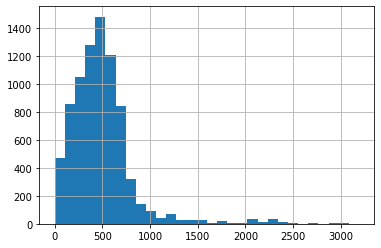

In [21]:
display(data['parks_nearest'].describe()) #расстояние до ближайшего парка
data['parks_nearest'].hist(bins=30)

1. Общая площадь: средняя больше медианы, что говорит о влиянии квартир с значительно большей площадью
2. Жилая площидь: есть значения, которые меньше установленных ЖК РФ по жилой площади квартир -> их убираем (причины: неправильно заполненные данные)
3. Площадь кухни: см. пункт выше
4. Цена: аналогично пункту 1, большое влияние цен элитных квартир
5. Кол-во комнат: квартиры с 0 комнат - это, как я понял, студии (?)
6. Высота потолка: были обработаны аномальные значения > 10.4 м и < 2.2 м
7. Тип этажа квартиры: первых и последних этажей +/- одинаковое кол-во
8. Общее кол-во этажей в доме: есть два пика - 5 этажей и 9 этажей (логично: хрущевки и брежневки)
9. Расстояние до центра города: график похож на нормальное распределение
10. Расстояние до ближайшего парка: см. пункт выше

#### Исследование срока с момента размещения объявления до его снятия

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

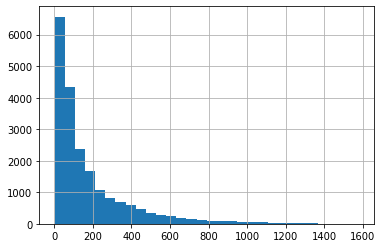

In [22]:
display(data['days_exposition'].describe()) #сколько дней было размещено объявление
data['days_exposition'].hist(bins=30)

<AxesSubplot:>

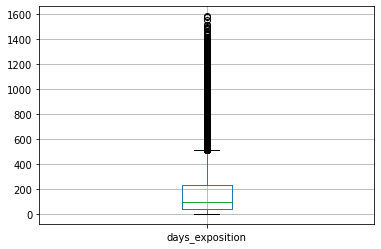

In [23]:
data.boxplot('days_exposition')
#plt.show()

Среднее арифметическое время продажи составляет полгода (180,9 дней), медиана чуть больше 3 месяцев (95 дней), если судить по диаграмме размаха, то датафрейме имеется очень много выбросов вплоть до 1600 дней. Субъективно: продать квартиру за 1-2 дня - маловероятно, эти продажи можно считать необычно быстрыми, то что больше 1,5 года - необычно долгими. Медиана более точно отражает время продажи квартиры

In [24]:
good_data = data.query('2 < days_exposition < 547.5')
good_data['days_exposition'].describe()

count    19028.000000
mean       132.643578
std        127.142251
min          3.000000
25%         42.000000
50%         86.000000
75%        188.000000
max        547.000000
Name: days_exposition, dtype: float64

#### Исследование факторов, влияющих на стоимость объекта

0.6310153165209474

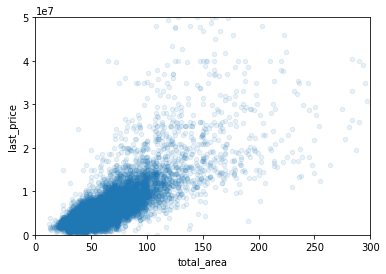

In [25]:
good_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1) #зависимость цены от общей площади
plt.xlim(0, 300)
plt.ylim(0, 50000000)
good_data['total_area'].corr(good_data['last_price']) #коэф. корреляции

1. Чем больше общая площадь объекта, тем выше цена

0.5449128590060996

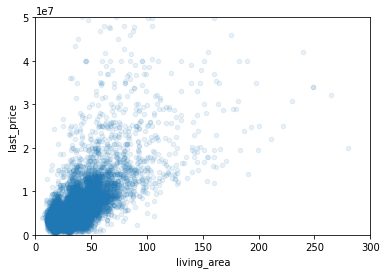

In [26]:
good_data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1) #зависимость цены от жилой площади
plt.xlim(0, 300)
plt.ylim(0, 50000000)
good_data['living_area'].corr(good_data['last_price']) #коэф. корреляции

2. Чем больше жилая площадь, тем выше цена (коэф. корреляции ниже 0,54 против 0,63)

0.4983517942981275

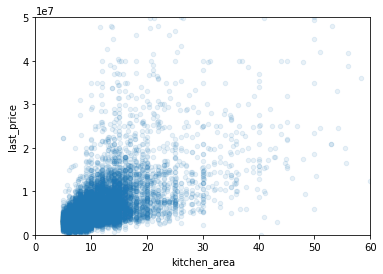

In [27]:
good_data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1) #зависимость цены от площади кухни
plt.xlim(0, 60)
plt.ylim(0, 50000000)
good_data['kitchen_area'].corr(good_data['last_price']) #коэф. корреляции

3. Чем больше площадь кухни, тем выше цена (коэф. корреляции еще ниже - 0,5)

(0.0, 50000000.0)

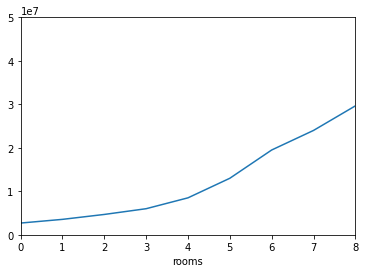

In [95]:
rooms_stat = good_data.pivot_table(index='rooms', values='last_price', aggfunc=['median', 'count']) #создаем сводную таблицу с медианным значением цены в зависимости от кол-ва комнат
rooms_stat.columns = ['median', 'count']
rooms_stat['median'].plot()
plt.xlim(0, 8)
plt.ylim(0, 50000000)
#я не понял как сделать гистограмму где по оси x - комнаты, а по оси y - цена (ниже ситуация аналогичная)

4. Чем больше комнат, тем выше цена (у объектов, где комнат больше 7 - малая выборка и корреляция отсутствует)

In [30]:
good_data.pivot_table(index='floor_type', values='last_price', aggfunc=['median', 'count']) #создаем сводную таблицу с медианным значением цены в зависимости от типа этажа

,median,count
,last_price,last_price
floor_type,,
другой,4650000.0,14174
первый,3800000.0,2269
последний,4200000.0,2585


5. Цены объектов, которые расположены на первом и последнем этажах ниже цен на других этажах. Цены объектов на первом этаже ниже цен на последенем

<AxesSubplot:xlabel='day_of_week'>

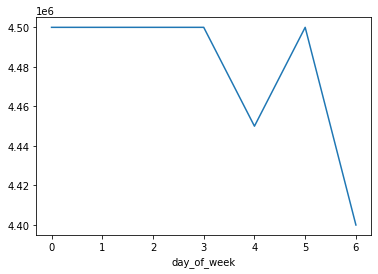

In [96]:
day_of_week_stat = good_data.pivot_table(index='day_of_week', values='last_price', aggfunc=['median', 'count']) #создаем сводную таблицу с медианным значением цены в зависимости от дня недели
day_of_week_stat.columns = ['median', 'count']
day_of_week_stat['median'].plot()

6. Цены не зависят от дня недели размещения объявления

<AxesSubplot:xlabel='month'>

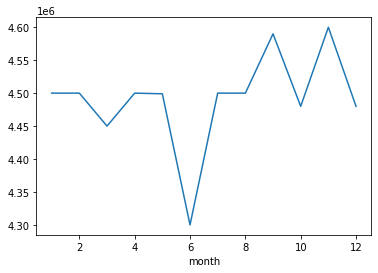

In [97]:
month_stat = good_data.pivot_table(index='month', values='last_price', aggfunc=['median', 'count']) #создаем сводную таблицу с медианным значением цены в зависимости от месяца
month_stat.columns = ['median', 'count']
month_stat['median'].plot()

7. Цены не зависят от месяца размещения объявления

<AxesSubplot:xlabel='year'>

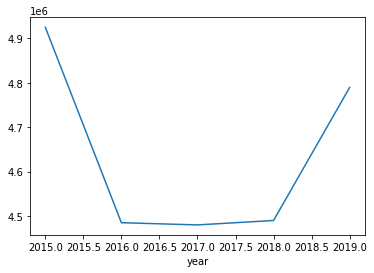

In [98]:
year_stat = good_data.pivot_table(index='year', values='last_price', aggfunc=['median', 'count']) #создаем сводную таблицу с медианным значением цены в зависимости от года
year_stat.columns = ['median', 'count']
year_stat['median'].plot()

8. Зависимость цены от года размещения неоднозначна. В 2015 году цена самая высокая, затем произошло падение, а далее наблюдается рост цен

#### Исследование стоимости одного кв. метра по населенным пунктам

In [54]:
locality_stat = good_data.pivot_table(index='locality_name', values='price_per_square', aggfunc=['mean', 'median', 'count'])
locality_stat.columns = ['mean_price_per_square', 'median_price_per_square', 'count']
locality_stat.sort_values(by='count', ascending=False).head(10)

,mean_price_per_square,median_price_per_square,count
locality_name,,,
Санкт-Петербург,111798.190559,102941.176471,12597
поселок Мурино,85899.102121,86171.497585,524
поселок Шушары,77976.127316,76125.000000,391
Всеволожск,68639.798593,65540.540541,309
Колпино,74772.126214,73728.813559,295
поселок Парголово,89199.549040,91243.680790,290
Пушкин,101679.194377,97625.329815,281
деревня Кудрово,92602.351164,92044.864227,272
Гатчина,68125.554990,67187.500000,247


Самая высокая средняя цена за 1 кв. метр недвижимости среди 10 населенных пунктов с наибольшим числом объявлений в Санкт-Петербурге - 111798,2; Самая низкая стоимость за 1 кв. метр в Выборге - 56980,9

#### Исследование стоимости квартир на разном удалении от центра

,last_price
dist_to_city,
0.0,2.896125e+07
1.0,2.011940e+07
2.0,1.774146e+07
3.0,1.003073e+07
4.0,1.311004e+07
5.0,1.350179e+07
6.0,1.433357e+07
7.0,1.282526e+07
8.0,9.398096e+06


<AxesSubplot:xlabel='dist_to_city'>

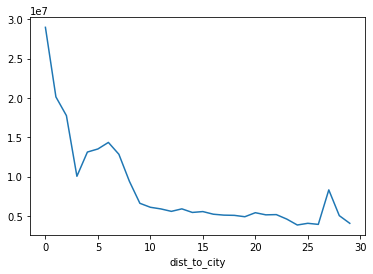

In [102]:
real_estate_sp = good_data.query('locality_name == "Санкт-Петербург"').pivot_table(index='dist_to_city', values='last_price')
display(real_estate_sp)
real_estate_sp['last_price'].plot()

Стоимость квартир снижается по мере удаления от центра города. Однако есть два пика в районе 6 км и 27 км. Возможно пики обусловлены элитными жилыми комплексами.

### Напишите общий вывод

Среднее время продажи объекта недвижимости после размещения объявления составляет 95 дней. На стоимость объекта в большей степени влияет его общая площадь (коэф. корреляции 0,63), так же имеет значение жилая площадь (+ корреляция), площадь кухни (+ корреляция), кол-во комнат (с увеличением кол-ва комнат растет и цена), этаж (если это первый/последний - цена ниже). Самая высокая средняя цена за 1 кв. метр недвижимости среди 10 населенных пунктов с наибольшим числом объявлений в Санкт-Петербурге - 111798,2. Самая низкая стоимость за 1 кв. метр в Выборге - 56980,9. В Санкт-Петербурге стоимость квартир снижается по мере удаления от центра города. Однако есть два пика в районе 6 км и 27 км. Возможно, пики обусловлены элитными жилыми комплексами.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.